Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import numpy as np
import pingouin as pg
from scipy.stats import pearsonr

Import and merge summary statistics

In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
behavior_df = pd.read_csv(path + '/data/behavior.txt')
metadprime_df = pd.read_csv(path + '/data/metadprimeHmetad.txt', sep='\t')
metadprime_df = metadprime_df.groupby(['Subject', 'Session', 'Modality']).mean().reset_index()

del1_df = pd.read_csv(path + '/data/Del1_psychophysics.txt')
del2_df = pd.read_csv(path + '/data/Del2_psychophysics.txt')
del1_df['Session'] = 'Del1'
del2_df['Session'] = 'Del2'
psychophysics_df = del1_df.append(del2_df)

sdt_df = pd.read_csv(path + '/data/sdt.txt')

psychophysics_df = psychophysics_df[['Subject', 'Session', 'Modality', 'Threshold', 'Slope', 'BayesianThreshold', 'BayesianSlope']]
behavior_df = behavior_df[['Confidence', 'ConfidenceRT', 'DecisionRT', 'Modality', 'Subject', 'Session', 'Corruption']]
metadprime_df = metadprime_df[['MetadPrime', 'Subject', 'Modality', 'Session']]
summary_df = pd.merge(psychophysics_df, behavior_df, on=['Subject', 'Modality', 'Session']).merge(metadprime_df, on=['Subject', 'Modality', 'Session']).merge(sdt_df[['Subject', 'Session', 'Modality', 'd', 'c']], on=['Subject', 'Modality', 'Session'])

In [3]:
summary_df.to_csv(path + '/data/summary.txt', index=False)

# Session 1

In [7]:
summary_df = pd.read_csv(path + '/data/summary.txt')

extero = summary_df[(summary_df.Modality=='Extero') & (summary_df.Session=='Del1')]
intero = summary_df[(summary_df.Modality=='Intero') & (summary_df.Session=='Del1')]

intero.drop(['Modality'], axis=1, inplace=True)
intero.rename(columns={'BayesianThreshold':'Interoception - Threshold',
                       'BayesianSlope': 'Interoception - Slope',
                       'Confidence': 'Interoception - Confidence',
                       'c': 'Interoception - Criterion',
                       'DecisionRT': 'Interoception - RT',
                       'd': 'Interoception - d\'',
                       'MetadPrime': 'Interoception - meta-d\''}, inplace=True)
extero.drop(['Modality'], axis=1, inplace=True)
extero.rename(columns={'BayesianThreshold':'Exteroception - Threshold',
                       'BayesianSlope': 'Exteroception - Slope',
                       'Confidence': 'Exteroception - Confidence',
                       'c': 'Exteroception - Criterion',
                       'DecisionRT': 'Exteroception - RT',
                       'd': 'Exteroception - d\'',
                       'MetadPrime': 'Exteroception - meta-d\''}, inplace=True)
summary_df = pd.merge(extero, intero, on=['Subject'])

summary_df.loc[:, 'Exteroception - m-ratio'] = summary_df['Exteroception - meta-d\'']/summary_df['Exteroception - d\'']
summary_df.loc[:, 'Interoception - m-ratio'] = summary_df['Interoception - meta-d\'']/summary_df['Interoception - d\'']

Reorder columns

In [8]:
summary_df = summary_df[
['Subject', 
  'Exteroception - Threshold',
  'Exteroception - Slope',
  'Exteroception - d\'', 
  'Exteroception - Criterion',
  'Exteroception - RT', 
  'Exteroception - Confidence', 
  'Exteroception - meta-d\'',
  'Exteroception - m-ratio',
  'Interoception - Threshold', 
  'Interoception - Slope',
  'Interoception - d\'', 
  'Interoception - Criterion',
  'Interoception - RT', 
  'Interoception - Confidence', 
  'Interoception - meta-d\'',
  'Interoception - m-ratio']]

## Preprocessing

In [9]:
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(145, 300, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

corr = summary_df.corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['X', 'Y', 'correlation']

pval = summary_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*summary_df.corr().shape)
pval = pd.melt(pval.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
pval.columns = ['X', 'Y', 'pval']

corr = pd.merge(corr, pval, on=['X', 'Y'])

# Highlight upper triangle
upper_df = summary_df.corr().where(~np.triu(np.ones(summary_df.corr().shape)).astype(np.bool), other='upper')
upper_df = pd.melt(upper_df.reset_index(), id_vars='index')
upper_df.columns = ['X', 'Y', 'upper']

corr = pd.merge(corr, upper_df, on=['X', 'Y'])

# Correct for muli comparisons
h, p = pg.multicomp(corr[corr['upper'] == 'upper']['pval'].to_numpy(), method='fdr_bh', alpha=0.01)
corr['pval'].loc[corr['upper'] == 'upper'] = p

# Color of non significant results
corr['color'] = corr['correlation'].apply(value_to_color)
corr['color'].loc[corr['pval'] > .05] = 'white'

# Size of non significant results
corr['size'] = corr['correlation'].abs()
corr['size'].loc[corr['pval'] > .05] = 0

# Set color and size for diagonal
corr['size'].loc[corr['X'] == corr['Y']] = .1
corr['color'].loc[corr['X'] == corr['Y']] = 'k'

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Plot

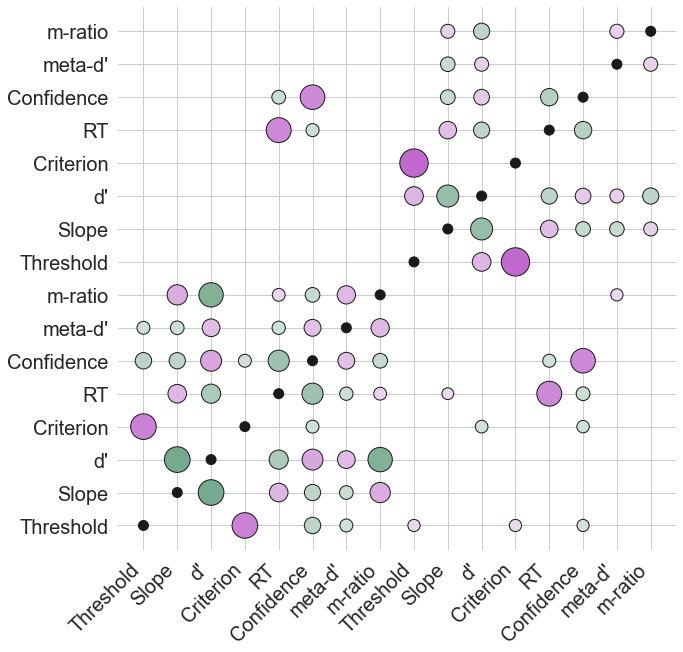

In [10]:
sns.set_theme(style="whitegrid")

def heatmap(x, y, size, color):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 1000
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color,
        marker='o', # Use square as scatterplot marker
        edgecolors='k',
        label=color,
        cmap='viridis'
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

    labels = [item.get_text()
          .replace('Interoception - ', '')
          .replace('Exteroception - ', '')for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels, size=20)

    labels = [item.get_text()
          .replace('Interoception - ', '')
          .replace('Exteroception - ', '')for item in ax.get_yticklabels()]
    ax.set_yticklabels(labels, size=20)

    sns.despine(left=True, bottom=True)

heatmap(x=corr['X'], y=corr['Y'], size=corr['size'], color=corr['color'])
plt.savefig(path + '/figures/Fig4_heatmap.svg', dpi=300)

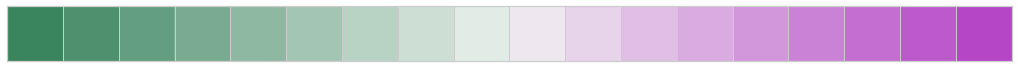

In [11]:
sns.palplot(sns.diverging_palette(145, 300, n=18))
plt.savefig(path + '/figures/Fig4_heatmap_colorbar.svg', dpi=300)

# Session 2

In [12]:
summary_df = pd.read_csv(path + '/data/summary.txt')

extero = summary_df[(summary_df.Modality=='Extero') & (summary_df.Session=='Del2')]
intero = summary_df[(summary_df.Modality=='Intero') & (summary_df.Session=='Del2')]

intero.drop(['Modality'], axis=1, inplace=True)
intero.rename(columns={'BayesianThreshold':'Interoception - Threshold',
                       'BayesianSlope': 'Interoception - Slope',
                       'Confidence': 'Interoception - Confidence',
                       'c': 'Interoception - Criterion',
                       'DecisionRT': 'Interoception - RT',
                       'd': 'Interoception - d\'',
                       'MetadPrime': 'Interoception - meta-d\''}, inplace=True)
extero.drop(['Modality'], axis=1, inplace=True)
extero.rename(columns={'BayesianThreshold':'Exteroception - Threshold',
                       'BayesianSlope': 'Exteroception - Slope',
                       'Confidence': 'Exteroception - Confidence',
                       'c': 'Exteroception - Criterion',
                       'DecisionRT': 'Exteroception - RT',
                       'd': 'Exteroception - d\'',
                       'MetadPrime': 'Exteroception - meta-d\''}, inplace=True)
summary_df = pd.merge(extero, intero, on=['Subject'])

summary_df.loc[:, 'Exteroception - m-ratio'] = summary_df['Exteroception - meta-d\'']/summary_df['Exteroception - d\'']
summary_df.loc[:, 'Interoception - m-ratio'] = summary_df['Interoception - meta-d\'']/summary_df['Interoception - d\'']

Reorder columns

In [13]:
summary_df = summary_df[
['Subject', 
  'Exteroception - Threshold',
  'Exteroception - Slope',
  'Exteroception - d\'', 
  'Exteroception - Criterion',
  'Exteroception - RT', 
  'Exteroception - Confidence', 
  'Exteroception - meta-d\'',
  'Exteroception - m-ratio',
  'Interoception - Threshold', 
  'Interoception - Slope',
  'Interoception - d\'', 
  'Interoception - Criterion',
  'Interoception - RT', 
  'Interoception - Confidence', 
  'Interoception - meta-d\'',
  'Interoception - m-ratio']]

## Preprocessing

In [14]:
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(145, 300, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

corr = summary_df.corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['X', 'Y', 'correlation']

pval = summary_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*summary_df.corr().shape)
pval = pd.melt(pval.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
pval.columns = ['X', 'Y', 'pval']

corr = pd.merge(corr, pval, on=['X', 'Y'])

# Highlight upper triangle
upper_df = summary_df.corr().where(~np.triu(np.ones(summary_df.corr().shape)).astype(np.bool), other='upper')
upper_df = pd.melt(upper_df.reset_index(), id_vars='index')
upper_df.columns = ['X', 'Y', 'upper']

corr = pd.merge(corr, upper_df, on=['X', 'Y'])

# Correct for muli comparisons
h, p = pg.multicomp(corr[corr['upper'] == 'upper']['pval'].to_numpy(), method='fdr_bh', alpha=0.01)
corr['pval'].loc[corr['upper'] == 'upper'] = p

# Color of non significant results
corr['color'] = corr['correlation'].apply(value_to_color)
corr['color'].loc[corr['pval'] > .05] = 'white'

# Size of non significant results
corr['size'] = corr['correlation'].abs()
corr['size'].loc[corr['pval'] > .05] = 0

# Set color and size for diagonal
corr['size'].loc[corr['X'] == corr['Y']] = .1
corr['color'].loc[corr['X'] == corr['Y']] = 'k'

## Plot

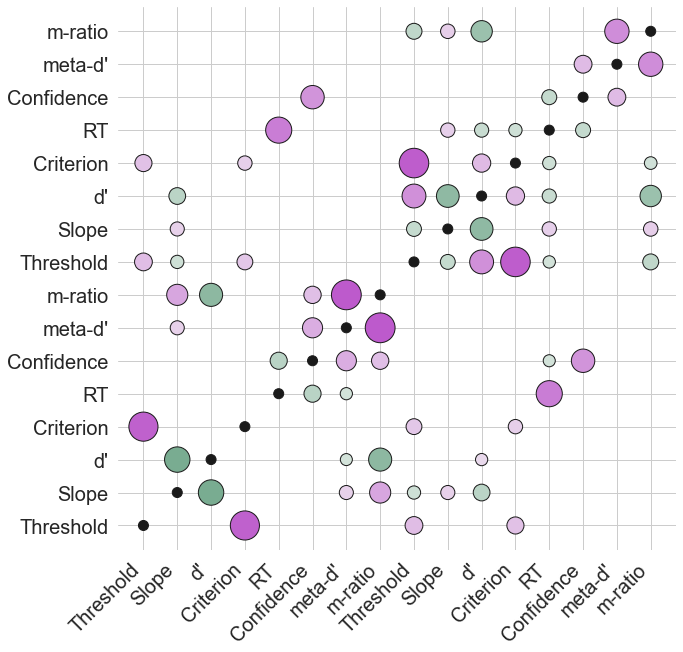

In [15]:
sns.set_theme(style="whitegrid")

def heatmap(x, y, size, color):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 1000
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color,
        marker='o', # Use square as scatterplot marker
        edgecolors='k',
        label=color,
        cmap='viridis'
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

    labels = [item.get_text()
          .replace('Interoception - ', '')
          .replace('Exteroception - ', '')for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels, size=20)

    labels = [item.get_text()
          .replace('Interoception - ', '')
          .replace('Exteroception - ', '')for item in ax.get_yticklabels()]
    ax.set_yticklabels(labels, size=20)
    
    #kw = dict(prop="colors", num=10, fmt="$ {x:.2f}",
    #          )
    #legend2 = ax.legend(*scatter.legend_elements(**kw),
    #                    loc='center left', bbox_to_anchor=(1, 0.5), title="Pearson's r")
    sns.despine(left=True, bottom=True)

heatmap(x=corr['X'], y=corr['Y'], size=corr['size'], color=corr['color'])
plt.savefig(path + '/figures/Fig5_heatmap2.png', dpi=300)

# Correlations with the Heartbeat Counting task

In [16]:
del1_df = pd.read_csv(path + '/data/Del1_psychophysics.txt')
hbc_df = pd.read_csv(path + '/data/hbc.txt')

In [17]:
summary_df = pd.merge(del1_df, hbc_df.groupby(['Subject']).mean(), on=['Subject'])

In [18]:
summary_df.Subject.nunique()

192

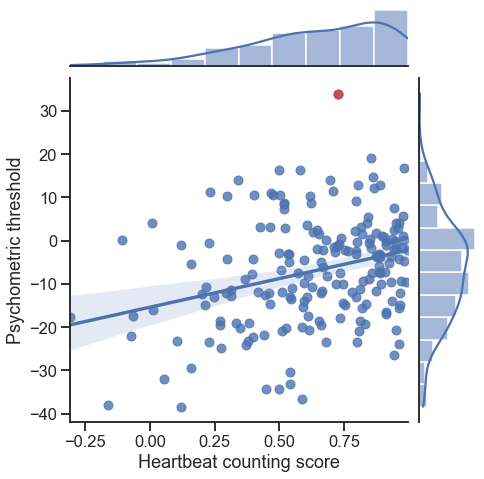

In [35]:
sns.set(style="white", color_codes=True)
sns.set_context('talk')
g = sns.jointplot(
    data=summary_df[summary_df.Modality=='Intero'],
    y='BayesianThreshold', x='Score', kind='reg', height=7)
g.ax_joint.set_ylabel('Psychometric threshold')
g.ax_joint.set_xlabel('Heartbeat counting score')

_, _, outliers = pg.correlation.skipped(
    y=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy(),
    x=summary_df['Score'][summary_df.Modality=='Intero'].to_numpy())
g.ax_joint.plot(summary_df['Score'][summary_df.Modality=='Intero'].to_numpy()[outliers],
                summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy()[outliers],
                'ro')
g.ax_joint.tick_params(axis='both', which='major', bottom=True, left=True)

plt.savefig(path + '/figures/Fig5_HBC_corr.svg', dpi=300)

In [32]:
pg.corr(y=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy(),
        x=summary_df['Score'][summary_df.Modality=='Intero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,192,1,0.271505,"[0.14, 0.4]",0.073715,0.063913,0.000145,0.969787


In [21]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Modality=='Extero'].to_numpy(),
        y=summary_df['Score'][summary_df.Modality=='Extero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,192,10,-0.042909,"[-0.18, 0.1]",0.001841,-0.008721,0.565189,0.090868


In [22]:
summary_df = pd.merge(del1_df, hbc_df.groupby(['Subject']).sum(), on=['Subject'])

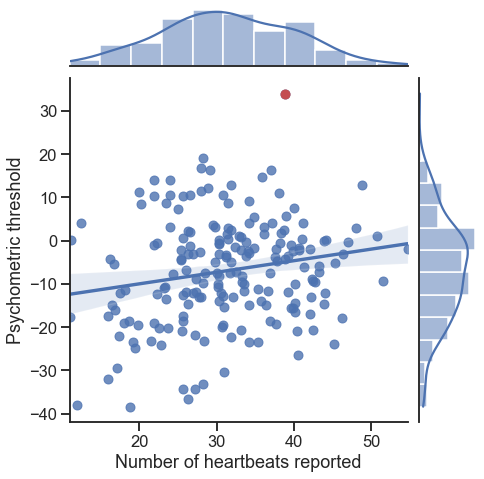

In [36]:
g = sns.jointplot(
    data=summary_df[summary_df.Modality=='Intero'],
    y='BayesianThreshold', x='Reported', kind='reg', height=7)
g.ax_joint.set_ylabel('Psychometric threshold')
g.ax_joint.set_xlabel('Number of heartbeats reported')

_, _, outliers = pg.correlation.skipped(
    y=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy(),
    x=summary_df['Reported'][summary_df.Modality=='Intero'].to_numpy())
g.ax_joint.plot(summary_df['Reported'][summary_df.Modality=='Intero'].to_numpy()[outliers],
                summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy()[outliers],
                'ro')
g.ax_joint.tick_params(axis='both', which='major', bottom=True, left=True)

plt.savefig(path + '/figures/Fig5_HBC_corr2.svg', dpi=300)

In [29]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy(),
        y=summary_df['Reported'][summary_df.Modality=='Intero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,192,1,0.153587,"[0.01, 0.29]",0.023589,0.013256,0.033898,0.568758


In [37]:
pg.partial_corr(data=summary_df[summary_df.Modality=='Intero'], x='BayesianThreshold', y='Reported', y_covar='Counts', method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,192,2,0.21186,"[0.07, 0.34]",0.044885,0.034778,0.003342,0.84239


In [31]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Modality=='Extero'].to_numpy(),
        y=summary_df['Reported'][summary_df.Modality=='Extero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,192,4,0.006893,"[-0.13, 0.15]",0.000048,-0.010534,0.9252,0.05095


## Reliability

In [24]:
del1_df = pd.read_csv(path + '/data/Del1_psychophysics.txt')
del2_df = pd.read_csv(path + '/data/Del2_psychophysics.txt')
summary_df = pd.merge(del1_df, del2_df, on=['Subject', 'Modality'])

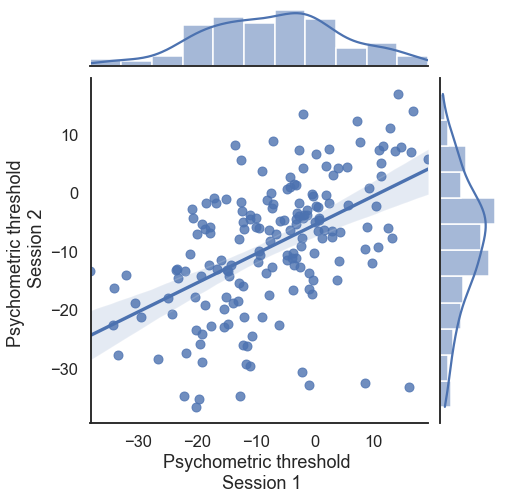

In [25]:
sns.set_context('talk')
g = sns.jointplot(
    data=summary_df[summary_df.Modality=='Intero'],
    y='BayesianThreshold_y', x='BayesianThreshold_x', kind='reg', height=7)
g.ax_joint.set_ylabel('Psychometric threshold \n Session 2')
g.ax_joint.set_xlabel('Psychometric threshold \n Session 1')

plt.savefig(path + '/figures/Fig6_threshold.svg', dpi=300)

In [26]:
pg.corr(x=summary_df['BayesianThreshold_x'][summary_df.Modality=='Intero'].to_numpy(),
        y=summary_df['BayesianThreshold_y'][summary_df.Modality=='Intero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,173,0,0.529463,"[0.41, 0.63]",0.280331,0.271864,6.912243e-14,1.0


In [12]:
summary_df = pd.read_csv(path + '/data/summary.txt')

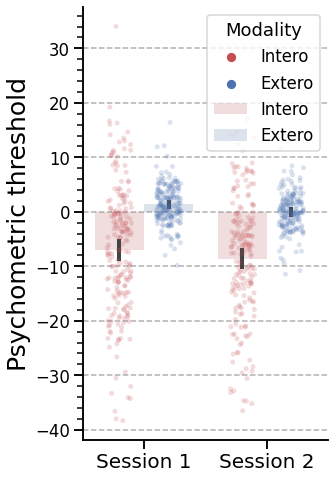

In [29]:
sns.set_context('talk')

fig, ax = plt.subplots(1, 1, figsize=(5, 7), sharey='row')

sns.stripplot(data=summary_df, x='Session', y='BayesianThreshold', hue='Modality', dodge=1, edgecolors='k', palette=['#c44e52', '#4c72b0'], alpha=0.2, jitter=0.2, ax=ax)
sns.barplot(data=summary_df, x='Session', y='BayesianThreshold', hue='Modality', alpha=0.2, palette=['#c44e52', '#4c72b0'], ax=ax)

plt.xticks([0, 1], ['Session 1', 'Session 2'], size=20)
plt.xlabel('')
ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', axis='y',linestyle='--')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_ylabel('Psychometric threshold', size=25)
plt.tight_layout()
sns.despine()
plt.savefig(os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + f'/figures/Figure6_stripplots.svg', dpi=300)

In [32]:
summary_df[summary_df.Session=='Del2'].Subject.nunique()

186

In [37]:
summary_df[(summary_df.Session=='Del1') & (summary_df.Modality=='Extero')].BayesianThreshold.to_numpy().mean()

1.3631379310344827

In [39]:
pg.ttest(x=summary_df[(summary_df.Session=='Del1') & (summary_df.Modality=='Extero')].BayesianThreshold.to_numpy(), y=0)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,5.443893,202,two-sided,1.502555e-07,"[0.87, 1.86]",0.382086,6.63e+04,0.999728


In [41]:
summary_df[(summary_df.Session=='Del2') & (summary_df.Modality=='Extero')].BayesianThreshold.to_numpy().mean()

0.02024731182795702

In [42]:
pg.ttest(x=summary_df[(summary_df.Session=='Del2') & (summary_df.Modality=='Extero')].BayesianThreshold.to_numpy(), y=0)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.078184,185,two-sided,0.937766,"[-0.49, 0.53]",0.005733,0.082,0.050693
